### Recommendation engine using collaborating filtering on Movielens

In [ ]:
import torch

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *
from fastai.imports import *

In [ ]:
path = '.'

In [ ]:
! ls .

collaborating filter.ipynb  ml-latest-small.zip  movielens.ipynb    tmp
ml-latest-small		    models		 ratings_small.csv


In [ ]:
ratings = pd.read_csv('ratings_small.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
ratings.shape

(100004, 4)

 There are no NAs

In [ ]:
n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [ ]:
print("n_users = ",n_users, "||", "n_movies = ", n_movies )

n_users =  671 || n_movies =  9066


Let's create a cross-tab for better visualization of user ids and item ids.

In [ ]:
g = ratings.groupby('userId')['rating'].count()
topg = g.sort_values(ascending = False)[:15]

i = ratings.groupby('movieId')['rating'].count()
topi = i.sort_values(ascending = False)[:15]

In [ ]:
# gettings ratings of top users and top items

join1 = ratings.join(topg, on='userId', how = 'inner', rsuffix='_r')
join1 = join1.join(topi, on='movieId', how = 'inner', rsuffix = '_r')

pd.crosstab(join1.userId, join1.movieId, join1.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


### Collaborative filtering

In [ ]:
val_indx = get_cv_idxs(len(ratings))  # index for validation set
wd = 2e-4 # weight decay
n_factors = 50 # n_factors

In [ ]:
# data loader
cf = CollabFilterDataset.from_csv(path, 'ratings_small.csv', 'userId', 'movieId', 'rating')

In [ ]:
learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)

In [ ]:
learn.fit(1e-2,2, wds = wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.7727   0.80396]                                    
[ 1.       0.77782  0.77585]                                    
[ 2.       0.58389  0.76542]                                    



We got .76

### Collaborating filter from scratch

In [ ]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])


In [ ]:
n_users, n_movies

(671, 9066)

`nn.Embedding` creates a lookup table that stores embeddings of a fixed dictionary and size. So word embeddings once stored can be retrieved using indices. After making `embeddings`, we get free `u.weights` which are correspondings weights of ebeddings

In [ ]:
val_indx = get_cv_idxs(len(ratings))  # index for validation set
wd = 2e-4 # weight decay
n_factors = 50 # n_factors i.e. 1 dimension of embeddings (random)

In [ ]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [ ]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    #e.weight.data.normal_(0,0.003)

    return e

In [ ]:
x = ratings.drop(['rating'],axis=1)
y = ratings['rating'].astype(np.float32)

data = ColumnarModelData.from_data_frame(path, val_indx, x, y, ['userId', 'movieId'], 64)

In [ ]:
# nh = dimension of hidden linear layer
# p1 = dropout1
# p2 = dropout2

class EmbeddingNet(nn.Module):
    def __init__(self, n_users, _n_movies, nh = 10, p1 = 0.05, p2= 0.5):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors),
            (n_users,1), (n_movies,1)
        ]]
        
        self.lin1 = nn.Linear(n_factors*2, nh)  # bias is True by default
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p = p1)
        self.drop2 = nn.Dropout(p = p2)
    
    def forward(self, cats, conts): # forward pass i.e.  dot product of vector from movie embedding matrixx
                                    # and vector from user embeddings matrix
        
        # torch.cat : concatenates both embedding matrix to make more columns, same rows i.e. n_factors*2, n : rows
        # u(users) is doing lookup for indexed mentioned in users
        # users has indexes to lookup in embedding matrix. 
        
        users,movies = cats[:,0],cats[:,1]
        u2,m2 = self.u(users) , self.m(movies)
       
        x = self.drop1(torch.cat([u2,m2], 1)) # drop initialized weights
        x = self.drop2(F.relu(self.lin1(x))) # drop 1st linear + nonlinear wt
        r = F.sigmoid(self.lin2(x)) * (max_rating - min_rating) + min_rating               
        return r

In [ ]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies)
model = model.cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd) # got parameter() for free , lr = 1e-3

In [ ]:
model

EmbeddingNet (
  (u): Embedding(671, 50)
  (m): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (mb): Embedding(9066, 1)
  (lin1): Linear (100 -> 10)
  (lin2): Linear (10 -> 1)
  (drop1): Dropout (p = 0.05)
  (drop2): Dropout (p = 0.5)
)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.74293  0.79247]                                    
[ 1.       0.74748  0.79483]                                    
[ 2.       0.75364  0.79638]                                    



In [ ]:
# from tqdm import tqdm as tqdm_cls

# inst = tqdm_cls._instances
# for i in range(len(inst)): inst.pop().close()

In [ ]:
set_lrs(opt, 1e-3)

In [ ]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.79631  0.78994]                                    
[ 1.       0.78677  0.79127]                                    
[ 2.      0.7614  0.7906]                                       



## Surprise package

In [ ]:
! ls .

collaborating filter.ipynb  ml-latest-small.zip  movielens.ipynb    tmp
ml-latest-small		    models		 ratings_small.csv


In [ ]:
! head -5 '/home/ubuntu/.surprise_data/ml-100k/ml-100k/u.data'

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596


In [ ]:
! head -5 'ratings_small.csv'

In [ ]:
from surprise import Reader, Dataset
# Define the format

reader = Reader(line_format='user item rating timestamp', sep='\t')
# Load the data from the file using the reader format

data = Dataset.load_from_file('/home/ubuntu/.surprise_data/ml-100k/ml-100k/u.data', reader=reader)

In [ ]:
ratings[:2]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [ ]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [ ]:
# Split data into 5 folds

data.split(n_folds=5)

In [ ]:
from surprise import SVD, evaluate

In [ ]:
from surprise import GridSearch

In [ ]:
param_grid = {'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
grid_search = GridSearch(SVD, param_grid, measures=['RMSE'])
grid_search.evaluate(data)

[{'lr_all': 0.002, 'reg_all': 0.4}, {'lr_all': 0.002, 'reg_all': 0.6}, {'lr_all': 0.005, 'reg_all': 0.4}, {'lr_all': 0.005, 'reg_all': 0.6}]
------------
Parameters combination 1 of 4
params:  {'lr_all': 0.002, 'reg_all': 0.4}
------------
Mean RMSE: 0.9133
------------
------------
Parameters combination 2 of 4
params:  {'lr_all': 0.002, 'reg_all': 0.6}
------------
Mean RMSE: 0.9214
------------
------------
Parameters combination 3 of 4
params:  {'lr_all': 0.005, 'reg_all': 0.4}
------------
Mean RMSE: 0.9031
------------
------------
Parameters combination 4 of 4
params:  {'lr_all': 0.005, 'reg_all': 0.6}
------------
Mean RMSE: 0.9121
------------


In [ ]:
algo = SVD()
evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8990
------------
Fold 2
RMSE: 0.8983
------------
Fold 3
RMSE: 0.8941
------------
Fold 4
RMSE: 0.8962
------------
Fold 5
RMSE: 0.8962
------------
------------
Mean RMSE: 0.8967
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.89895181594737417,
                             0.89831051013903251,
                             0.89405859774725671,
                             0.89621812893141306,
                             0.89617318551492264]})

As noticed above best RMSE from SVD is still higher than default result from fast.ai's neural net version for collaborative filtering using embeddings

### Let's try `KNN` algorithm also. 

In [ ]:
from surprise import KNNBasic

In [ ]:
algo = KNNBasic()
evaluate(algo, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9662
MAE:  0.7645
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9834
MAE:  0.7787
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9802
MAE:  0.7744
------------
Fold 4
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9812
MAE:  0.7728
------------
Fold 5
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9804
MAE:  0.7735
------------
------------
Mean RMSE: 0.9783
Mean MAE : 0.7728
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.76447687302283862,
                             0.77871336218916276,
                             0.77444253761129189,
                             0.77277756247233054,
                             0.77353073380751081],
                            'rmse': [0.96618541819639647,
                             0.98337516247695278,
                             0.98018440899082937,
                             0.98120591146396685,
                             0.98038668816669572]})

## NMF

In [ ]:
from surprise import NMF

In [ ]:
algo = NMF()
evaluate(algo, data, measures=['RMSE'])

Evaluating RMSE of algorithm NMF.

------------
Fold 1
RMSE: 0.9476
------------
Fold 2
RMSE: 0.9449
------------
Fold 3
RMSE: 0.9479
------------
Fold 4
RMSE: 0.9494
------------
Fold 5
RMSE: 0.9450
------------
------------
Mean RMSE: 0.9469
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9475771765522677,
                             0.94487435132530351,
                             0.94786484545358385,
                             0.94936598409066575,
                             0.94501542053063314]})

## cosine distance

In [ ]:
ratings = pd.read_csv('ratings_small.csv')

In [ ]:
ratings[:2]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [ ]:
ratings2 = ratings.copy()

In [ ]:
col = ['movieId', 'userId']

In [ ]:
for c in col:
    ratings2[c].replace({val: i for i, val in enumerate(ratings2[c].unique())}, inplace=True)

In [ ]:
ratings2[:2]

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179


In [ ]:
n_users=int(ratings2.userId.nunique())
n_items=int(ratings2.movieId.nunique())

In [ ]:
print("n_users = ",n_users, "||", "n_items = ", n_items )

n_users =  671 || n_items =  9066


In [ ]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(ratings2, test_size=0.25)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [ ]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [ ]:
print('User-based CF MSE: ' , str(mse(user_prediction, test_data_matrix)))
print('Item-based CF MSE: ' , str(mse(item_prediction, test_data_matrix)))

User-based CF MSE:  11.3668710905
Item-based CF MSE:  12.8400786831


## plot comparison

In [ ]:
import matplotlib.pyplot as plt

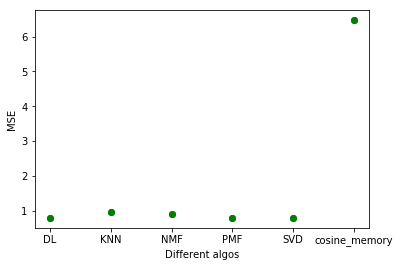

In [ ]:
mses = [6.47, .957, .897, .804, .801, .79]
algos = ['cosine_memory', 'KNN', "NMF", 'SVD', 'PMF', 'DL']
plt.plot(algos, mses, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("MSE")
plt.show()

In [ ]:
FileLink('collaborating_filter.ipynb')

/home/ubuntu/collaborate_filter/collaborating_filter.ipynb